# Electrophysiology analysis
This notebook will walk through the basic analysis of LFP and spike data during the virtual foraging task. It uses data that has already been preprocessed in the `intan_preprocessing` notebook.

## Initial setup

### Imports

In [2]:
# General
import os
import sys
import json
import struct

# Analysis
import numpy as np
import math

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Code
sys.path.insert(0, '../python/')
from session import Session, FreeSession
from util import flatten_list, MDAReader

In [147]:
import importlib
import util
importlib.reload(util)
from util import flatten_list, MDAReader, GoogleDriveHandler
from time import time

### Settings

In [145]:
### Directories ###
# Behavior data
labview_filepath = 'Y:/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
sess_filepath = None

# Raw ephys data
raw_dir = 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'

# Preprocessed ephys data (Google Drive API)
#timeseries_filepath = 'G:/My Drive/Projects/foraging/data/ephys_data/j6z4/02-04-19/raw1_w.mda'
#spikes_filepath = 'G:/My Drive/Projects/foraging/data/ephys_data/j6z4/02-04-19/firings1_r_-1_dt_4.npy'
#sort_metrics_filepath = 'G:/My Drive/Projects/foraging/data/ephys_data/j6z4/02-04-19/firings1_r_-1_dt_4_metrics.json'
#timestamps_filepath = 'G:/My Drive/Projects/foraging/data/ephys_data/j6z4/02-04-19/timestamps_daq_clock.npy'
timeseries_filepath = 'raw1_w.mda'
spikes_filepath = 'firings1_r_-1_dt_4.npy'
sort_metrics_filepath = 'firings1_r_-1_dt_4_metrics.json'
timestamps_filepath = 'timestamps_daq_clock.npy'
use_google_drive = True

### Parameters ###
# Spike sorting
rv_thresh = 0.5 # threshold for refractory violation period

# Autocorrelogram
dt_bin = 0.001
dt_bin_max = 0.100

# Waveform
dt_wf = 0.005 # window size (s)
fs = 30000 # sampling rate

### Google Drive API setup

In [142]:
results

{'kind': 'drive#fileList', 'incompleteSearch': False, 'files': []}

### Load behavior data

In [4]:
sess = FreeSession(labview_filepath)
if sess_filepath is not None:
    sess.load(sess_filepath)

## Spike analysis

### Load and filter spike data

In [148]:
# Load data
if use_google_drive:
    drive_handler = GoogleDriveHandler()
    
    spikes = drive_handler.download(spikes_filepath)
    t_intan = drive_handler.download(timestamps_filepath)
    t_spikes = t_intan[spikes[1, :].astype(np.int32)]
    mda_reader = MDAReader(timeseries_filepath, drive_file=True, drive_handler=drive_handler)
    
else:  
    spikes = np.load(spikes_filepath)
    t_intan = np.load(timestamps_filepath)
    t_spikes = t_intan[spikes[1, :].astype(np.int32)]
    mda_reader = MDAReader(timeseries_filepath, drive_file=False)


# Use active behavior period only
spikes = spikes[:, t_spikes > 0.0]
t_spikes = t_spikes[t_spikes > 0.0]

FileNotFoundError: [Errno 2] No such file or directory: 'firings1_r_-1_dt_4.npy'

#### Refractory violation period

In [6]:
# Filter clusters
sort_metrics = json.load(open(sort_metrics_filepath, 'r'))
cluster_ids = []
cluster_metrics = []
for c in sort_metrics['clusters']:
    label = c['label']
    refrac_violation = c['metrics']['refractory_violation_1msec']
    if refrac_violation < rv_thresh:
        cluster_ids.append(label)
        cluster_metrics.append(c['metrics'])    
cluster_ids = np.asarray(cluster_ids)

# Filter spikes, timestamps accordingly
keep_idx =  np.isin(spikes[2, :], cluster_ids)
spikes = spikes[:, keep_idx]
t_spikes = t_spikes[keep_idx]
num_units = len(cluster_ids)

print('Kept %d out of %d clusters.' % (cluster_ids.shape[0], label))

Kept 160 out of 210 clusters.


In [7]:
# mountainsort code at 
# https://github.com/magland/ml_ephys/blob/master/ml_ephys/basic/p_compute_cluster_metrics.py

In [8]:
# Compute autocorrelogram
isi = [] # inter-spike intervals
for i, unit in enumerate(cluster_ids):
    print('Processing unit %d (%d of %d)...' % (unit, i+1, len(cluster_ids)), end=' ')
    
    # Get spike times during behavior
    t_spikes_ = t_spikes[spikes[2, :] == unit]
    t_spikes_ = t_spikes_[t_spikes_ > 0]
    num_spikes = len(t_spikes_)

    # Placeholders
    idx = np.arange(num_spikes) # indices to compute ISI
    j = 1 # number of spikes ahead to compute ISI
    isi_ = [] # inter-spike intervals for unit
    while True:
        # Filter indices by max ISI for given step size
        idx = idx[idx + j < num_spikes] # handle end case
        idx = idx[t_spikes_[idx + j] - t_spikes_[idx] <= dt_bin_max] # limit max ISI

        # Compute ISI for given step size
        if idx.size > 0:
            isi_j = t_spikes_[idx + j] - t_spikes_[idx]
            isi_.append(isi_j)
            isi_.append(-isi_j)
            j += 1
            # No need to reset idx, since j has at least as many as j+1
        else:
            break
    
    # Save flattened list of ISIs
    isi.append(flatten_list(isi_))
    
    print('done.')

Processing unit 1 (1 of 160)... done.
Processing unit 3 (2 of 160)... done.
Processing unit 4 (3 of 160)... done.
Processing unit 5 (4 of 160)... done.
Processing unit 6 (5 of 160)... done.
Processing unit 7 (6 of 160)... done.
Processing unit 9 (7 of 160)... done.
Processing unit 12 (8 of 160)... done.
Processing unit 13 (9 of 160)... done.
Processing unit 16 (10 of 160)... done.
Processing unit 17 (11 of 160)... done.
Processing unit 18 (12 of 160)... done.
Processing unit 19 (13 of 160)... done.
Processing unit 21 (14 of 160)... done.
Processing unit 22 (15 of 160)... done.
Processing unit 23 (16 of 160)... done.
Processing unit 24 (17 of 160)... done.
Processing unit 27 (18 of 160)... done.
Processing unit 28 (19 of 160)... done.
Processing unit 29 (20 of 160)... done.
Processing unit 30 (21 of 160)... done.
Processing unit 31 (22 of 160)... done.
Processing unit 32 (23 of 160)... done.
Processing unit 33 (24 of 160)... done.
Processing unit 34 (25 of 160)... done.
Processing unit 

Processing unit 1 (1 of 160)... done.
Processing unit 3 (2 of 160)... done.
Processing unit 4 (3 of 160)... done.
Processing unit 5 (4 of 160)... done.
Processing unit 6 (5 of 160)... done.
Processing unit 7 (6 of 160)... done.
Processing unit 9 (7 of 160)... done.
Processing unit 12 (8 of 160)... done.
Processing unit 13 (9 of 160)... done.
Processing unit 16 (10 of 160)... done.
Processing unit 17 (11 of 160)... done.
Processing unit 18 (12 of 160)... done.
Processing unit 19 (13 of 160)... done.
Processing unit 21 (14 of 160)... done.
Processing unit 22 (15 of 160)... done.
Processing unit 23 (16 of 160)... done.
Processing unit 24 (17 of 160)... done.
Processing unit 27 (18 of 160)... done.
Processing unit 28 (19 of 160)... done.
Processing unit 29 (20 of 160)... done.
Processing unit 30 (21 of 160)... done.
Processing unit 31 (22 of 160)... done.
Processing unit 32 (23 of 160)... done.
Processing unit 33 (24 of 160)... done.
Processing unit 34 (25 of 160)... done.
Processing unit 

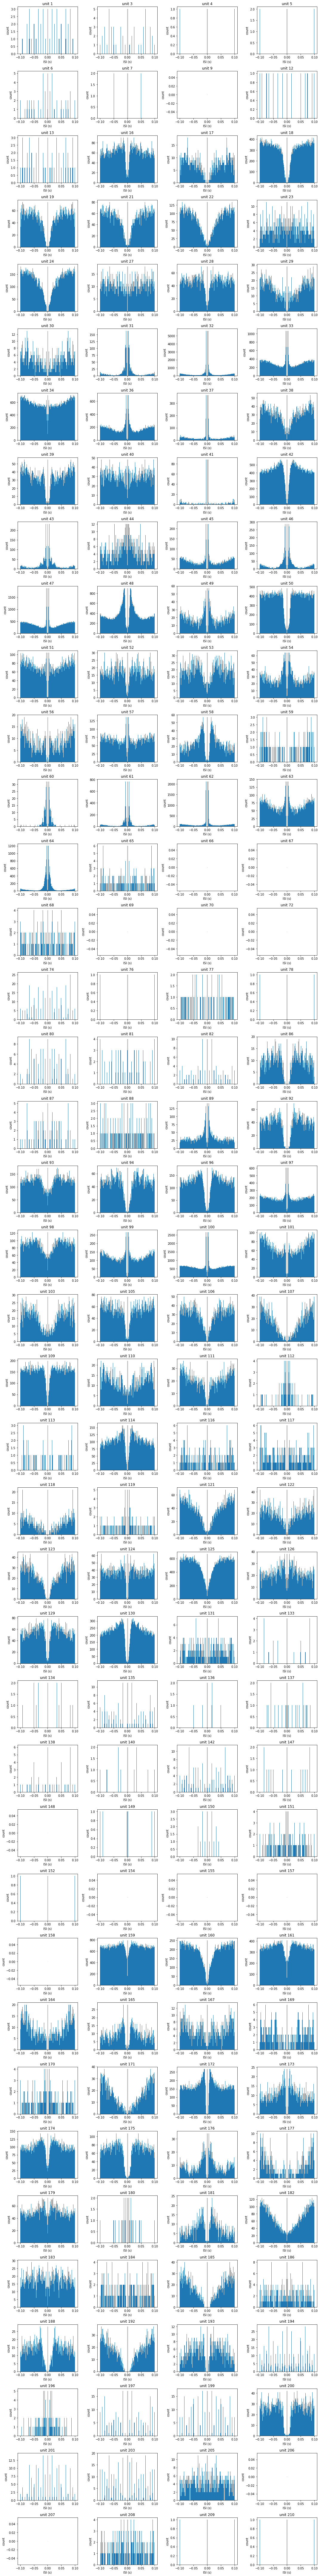

In [9]:
# Plot settings
cols = 4
rows = (num_units // cols) + (num_units % cols)
dt_refrac = 0.001 # refractory period (s)
num_bins = dt_bin_max // dt_bin
bin_edges = np.arange(-num_bins, num_bins+1) * dt_bin

fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))

for i, unit in enumerate(cluster_ids):
    print('Processing unit %d (%d of %d)...' % (unit, i+1, len(cluster_ids)), end=' ')
    
    # Set axis indices
    j = i // cols
    k = i % cols
    
    # Plot histogram and outline refractory period
    hist, _, _ = ax[j, k].hist(isi[i], bins=bin_edges)
    _ = ax[j, k].fill_between(np.array([-dt_refrac, dt_refrac]), y1=0.0, y2=np.max(hist),
                              alpha=0.2, color='black')
    
    # Axis settings
    ax[j, k].set_title('unit %d' % unit)
    ax[j, k].set_xlabel('ISI (s)')
    ax[j, k].set_ylabel('count')
    
    print('done.')

# Plot settings
plt.tight_layout();

#### Waveform template

In [73]:
# Setup
win_wf = int(dt_wf * fs)
wfs = np.zeros([num_units, mda_reader.num_channels, win_wf])

# Iterate through all units
for i, unit in enumerate(cluster_ids):
    t = time()
    print('Processing unit %d (%d of %d)...' % (unit, i+1, len(cluster_ids)), end=' ')
    
    # Get spike sample indices
    idx_spikes = spikes[1, spikes[2, :] == unit].astype(np.int64)

    # Iterate through all spikes
    for idx in idx_spikes:
        idx_start = idx - (win_wf // 2)
        idx_end = idx + (win_wf // 2)
        wfs[i, :, :] += mda_reader.read(sample_start=idx_start, sample_end=idx_end)

    # Get mean for each channel over all spikes
    wfs[i, :, :] /= len(idx_spikes) # memory-efficient form of getting mean
    
    print('done. (%d seconds)' % (time() - t))
    
# Convert to microvolts (see Intan data formats)
wfs *= 0.195

Processing unit 1 (1 of 160)... done. (0 seconds)
Processing unit 3 (2 of 160)... done. (0 seconds)
Processing unit 4 (3 of 160)... done. (0 seconds)
Processing unit 5 (4 of 160)... done. (0 seconds)
Processing unit 6 (5 of 160)... IOError: Retrying in one second...
IOError: Retrying in one second...
IOError: Retrying in one second...
IOError: Retrying in one second...
IOError: Retrying in one second...


OSError: Error reading file.

In [76]:
mda_reader.f.seek(0, 0)
b = mda_reader.f.read(mda_reader.num_channels * (idx_end - idx_start))

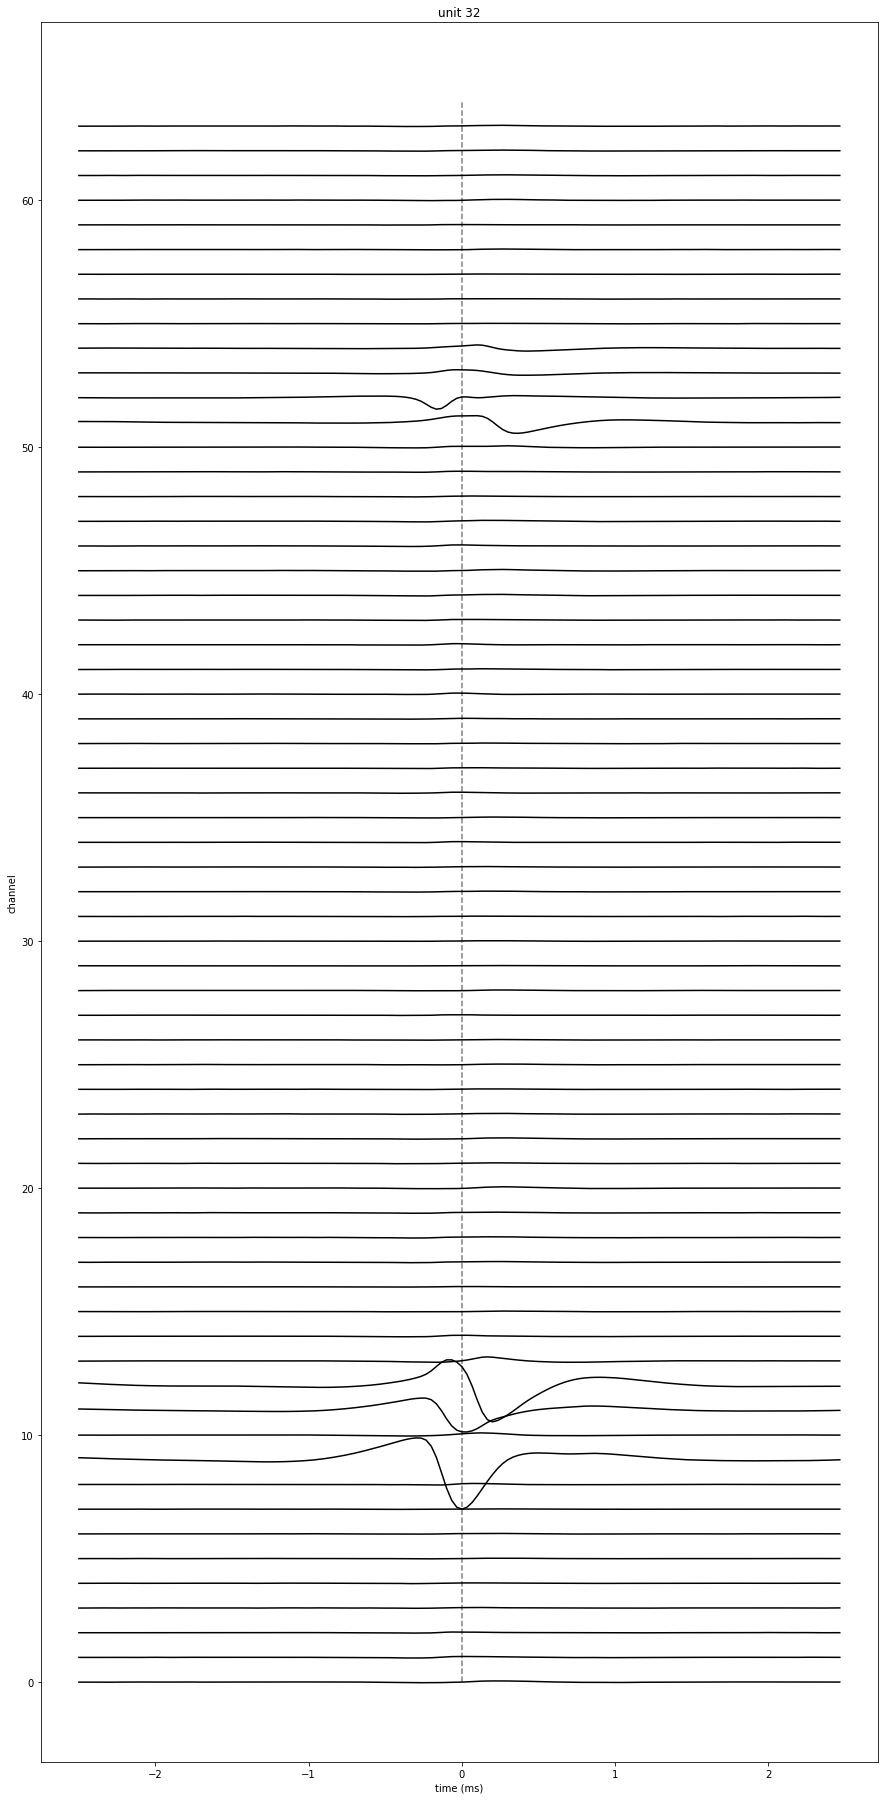

In [42]:
xx = np.arange(-X.shape[-1]//2, X.shape[-1]//2) / fs * 1000 

fig, ax = plt.subplots(figsize=(15, 0.5*mda_reader.num_channels))
scale = 2.0 / np.max(np.abs(X)) # rescale for aesthetics
  
for i in range(mda_reader.num_channels):
    ax.plot(xx, scale*X[i, :] + i, color='black')
    
ax.vlines(xx[len(xx)//2], ymin=0.0, ymax=mda_reader.num_channels,
          linestyle='--', color='gray')
ax.set_title('unit %d' % unit)
ax.set_xlabel('time (ms)')
ax.set_ylabel('channel');


In [43]:
X.shape

(64, 150)

### Plot spike raster across session

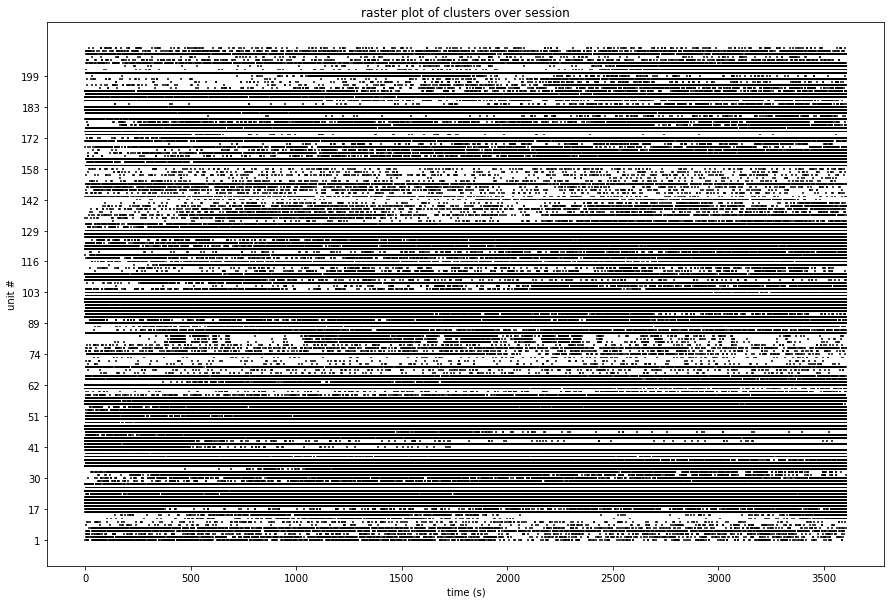

In [118]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 10))

# Raster plot
for i, c in enumerate(cluster_ids):
    t_spikes_ = t_spikes[spikes[2, :] == c]
    ax.vlines(t_spikes_, ymin=i-0.3, ymax=i+0.3)

# Plot settings
ax.set_yticks(np.arange(cluster_ids.shape[0])[::10])
ax.set_yticklabels(cluster_ids[::10])
ax.set_xlabel('time (s)')
ax.set_ylabel('unit #')
ax.set_title('raster plot of clusters over session');

### Peri-leaving activity

#### Settings

In [119]:
window = [-10.0, 10.0] # window around leaving decision
dt_bin = 0.020 # bin size (s)

#### Create smoothing kernel

In [120]:
def convolve(x, k, axis=0):
    if axis < 0:
        axis = x.ndim + axis
    a = axis
    b = x.ndim - axis - 1
    x_smooth = np.zeros(x.shape)
    for i in range(x.shape[axis]):
        slc = [slice(None)]*a + [i] + [slice(None)]*b
        idx = np.arange(x.shape[axis]) - i # zero-center mean
        k_i = k(idx)[[np.newaxis]*a + [slice(None)] + [np.newaxis]*b]
        x_smooth[slc] = np.sum(k_i * x, axis=axis)
    
    return x_smooth

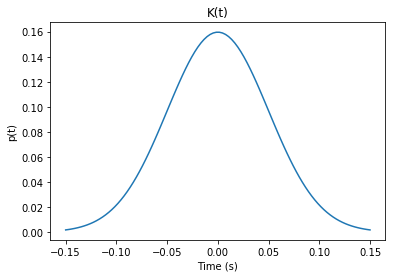

In [121]:
# Create kernel
sigma_k = 0.050 / dt_bin # kernel width (ms)
kernel = lambda x: 1/(2*math.pi*sigma_k**2)**0.5 * np.exp(-0.5 * x**2 / sigma_k**2)

# Plot kernel over +/- 3 standard deviations
xx = np.linspace(-3*sigma_k, 3*sigma_k, num=100)
fig, ax = plt.subplots()
ax.plot(xx*dt_bin, kernel(xx))
ax.set_title('K(t)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('p(t)');

#### Get firing rates

In [122]:
# Get leaving times
t_patch = sess.get_patch_times()
t_leave = t_patch[:-1, 1]

# Create time bins within patch-leaving window
bins = np.arange(window[0]/dt_bin, window[1]/dt_bin + dt_bin) * dt_bin
t_bins = t_leave[:, np.newaxis] + bins[np.newaxis, :]

# Placeholder
f_bin = np.zeros([len(cluster_ids), len(bins)-1])

# Iterate through units
for i, unit in enumerate(cluster_ids):
    print('Processing unit %d (%d of %d)...' % (unit, i+1, len(cluster_ids)))
    
    # Get spike times
    t_spikes_ = t_spikes[spikes[2, :] == unit]
    
    # Determine number of spikes in bins over all leaving windows
    in_bin = np.logical_and((t_spikes_[np.newaxis, np.newaxis, :] >= t_bins[:, :-1, np.newaxis]), 
                            (t_spikes_[np.newaxis, np.newaxis, :] <  t_bins[:, 1:, np.newaxis]))
    n_unit = np.sum(in_bin.astype(np.int32), axis=-1) # sum over spikes
    n_unit = np.mean(n_unit, axis=0) # take mean over trials
    
    # Discretized firing rate
    f_bin[i] = n_unit / dt_bin
    
# Smoothed firing rate
f_smooth = convolve(f_bin, kernel, axis=1)

Processing unit 1 (1 of 160)...
Processing unit 3 (2 of 160)...
Processing unit 4 (3 of 160)...
Processing unit 5 (4 of 160)...
Processing unit 6 (5 of 160)...
Processing unit 7 (6 of 160)...
Processing unit 9 (7 of 160)...
Processing unit 12 (8 of 160)...
Processing unit 13 (9 of 160)...
Processing unit 16 (10 of 160)...
Processing unit 17 (11 of 160)...
Processing unit 18 (12 of 160)...
Processing unit 19 (13 of 160)...
Processing unit 21 (14 of 160)...
Processing unit 22 (15 of 160)...
Processing unit 23 (16 of 160)...
Processing unit 24 (17 of 160)...
Processing unit 27 (18 of 160)...
Processing unit 28 (19 of 160)...
Processing unit 29 (20 of 160)...
Processing unit 30 (21 of 160)...
Processing unit 31 (22 of 160)...
Processing unit 32 (23 of 160)...
Processing unit 33 (24 of 160)...
Processing unit 34 (25 of 160)...
Processing unit 36 (26 of 160)...
Processing unit 37 (27 of 160)...
Processing unit 38 (28 of 160)...
Processing unit 39 (29 of 160)...
Processing unit 40 (30 of 160)

Processing unit 1 (1 of 160)...
Processing unit 3 (2 of 160)...
Processing unit 4 (3 of 160)...
Processing unit 5 (4 of 160)...
Processing unit 6 (5 of 160)...
Processing unit 7 (6 of 160)...
Processing unit 9 (7 of 160)...
Processing unit 12 (8 of 160)...
Processing unit 13 (9 of 160)...
Processing unit 16 (10 of 160)...
Processing unit 17 (11 of 160)...
Processing unit 18 (12 of 160)...
Processing unit 19 (13 of 160)...
Processing unit 21 (14 of 160)...
Processing unit 22 (15 of 160)...
Processing unit 23 (16 of 160)...
Processing unit 24 (17 of 160)...
Processing unit 27 (18 of 160)...
Processing unit 28 (19 of 160)...
Processing unit 29 (20 of 160)...
Processing unit 30 (21 of 160)...
Processing unit 31 (22 of 160)...
Processing unit 32 (23 of 160)...
Processing unit 33 (24 of 160)...
Processing unit 34 (25 of 160)...
Processing unit 36 (26 of 160)...
Processing unit 37 (27 of 160)...
Processing unit 38 (28 of 160)...
Processing unit 39 (29 of 160)...
Processing unit 40 (30 of 160)

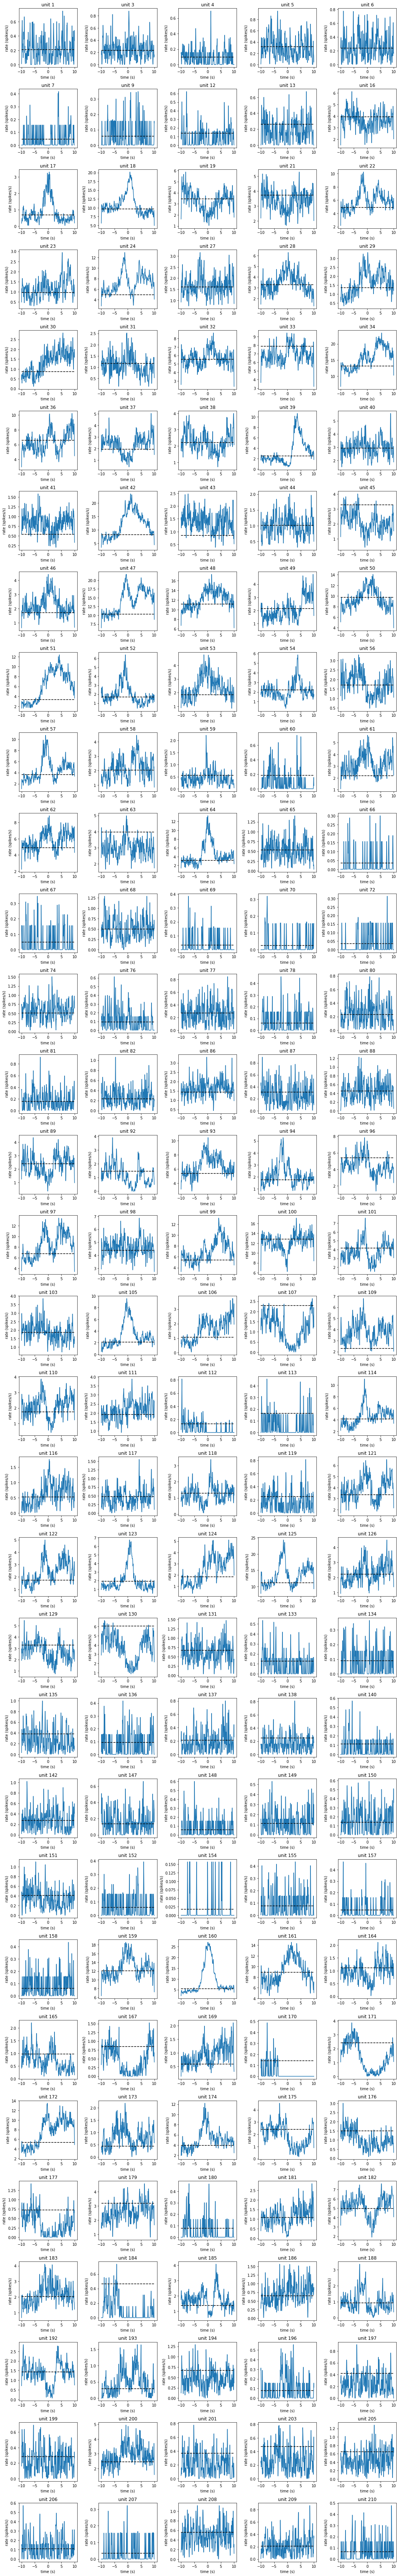

In [123]:
cols = 5
rows = (num_units // cols) + (num_units % cols)
xx = bins[:-1] + 0.5*dt_bin

fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))

for i, unit in enumerate(cluster_ids):
    print('Processing unit %d (%d of %d)...' % (unit, i+1, len(cluster_ids)))
    
    # Idxs
    j = i // cols
    k = i % cols
    
    # Plot smoothed firing rate within leaving window
    ax[j, k].plot(xx, f_smooth[i, :])
    
    # Plot average firing rate across session
    ax[j, k].plot(np.array([xx[0], xx[-1]]), np.array([cluster_metrics[i]['firing_rate']]*2),
                  linestyle='--', color='black')
    
    # Axis settings
    ax[j, k].set_title('unit %d' % unit)
    ax[j, k].set_xlabel('time (s)')
    ax[j, k].set_ylabel('rate (spikes/s)')

# Plot settings
plt.tight_layout()

In [ ]:
# maybe use autocorrelation coefficient to search for non-randomness in curves?

### Peri-reward activity

In [ ]:
if (i+1) % 1000 == 0:
        print('Processing spike %d of %d...' % (i+1, len(idx_spikes)))
    byte_start = header_length + n_bytes * num_channels * (idx - (win_wf // 2))
    f.seek(byte_start, 0)
    
    num_pts = num_channels * win_wf
    format_str = '%d%s' % (num_pts, format_char)
    wf = np.array(struct.unpack(format_str, f.read(n_bytes*num_pts)))
    #wf = np.fromfile(f, dtype=np.float32, count=num_pts)
    X[i, :, :] = wf.reshape([num_channels, win_wf], order='F')

## LFP analysis

In [247]:
f = open(timeseries_filepath, 'rb')
header_length = 0

# First 32 bits = signed integer indicating data type
code, = struct.unpack('i', f.read(4))
header_length += 4

# Second 32 bits: number of bytes per entry
entry_size, = struct.unpack('i', f.read(4))
header_length += 4

# Third 32 bits: number of dimensions
n_dims, = struct.unpack('i', f.read(4))
header_length += 4

# Next 32*n_dims bits: size of each dimension
shape = np.zeros(n_dims, dtype=np.int64)
for i in range(n_dims):
    shape[i], = struct.unpack('i', f.read(4))
    header_length += 4
print('Number of channels: %d' % shape[0])
print('Number of data points: %d' % shape[1])

# Determine data type from code
if code == -3: # float32
    n_bytes = 4
    format_char = 'f'
elif code == -4: # int16
    n_bytes = 2
    format_char = 'h'
elif code == -5: # int32
    n_bytes = 4
    format_char = 'i'
elif code == -6: # uint16
    n_bytes = 2
    format_char = 'H'
elif code == -7: # double
    n_bytes = 8
    format_char = 'd'
elif code == -8: # uint32
    n_bytes = 4
    format_char = 'I'
else:
    raise ValueError('Unknown code (%d).' % code)

Number of channels: 64
Number of data points: 116875200
